In [52]:
import pandas as pd

# cm_features = pd.read_csv('data/cm_features_with_name.csv')
cm_features = pd.read_csv('data/cm_features_v0.4.csv')
cm_features

,month_id,country_id,gleditsch_ward,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,...,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,country,date,year,ccode,gw_statename
0,121,1,110,0,0,0,0,0,0,0,...,315260.986388,354505.092577,0.093750,1.034032,0.093750,Guyana,1990-01-01,1990,110,Guyana
1,121,2,115,0,0,0,0,0,0,0,...,264606.831667,264606.831667,0.062500,0.062500,0.062500,Suriname,1990-01-01,1990,115,Surinam
2,121,3,52,0,0,0,0,0,0,0,...,3244.939711,3244.939711,0.000000,0.000000,0.000000,Trinidad and Tobago,1990-01-01,1990,52,Trinidad and Tobago
3,121,4,101,0,0,12,0,0,0,0,...,45295.968642,74555.476336,1.062500,1.062500,0.093750,Venezuela,1990-01-01,1990,101,Venezuela
4,121,7,160,0,0,0,0,0,0,0,...,9511.721633,28542.982753,0.874154,0.156250,0.156250,Argentina,1990-01-01,1990,160,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63203,502,242,510,0,0,1,0,0,2,30,...,1536.763246,1761.240449,4.412313,3.889290,2.105145,Tanzania,2021-10-01,2021,510,Tanzania/Tanganyika
63204,502,243,600,0,0,0,2,2,0,5,...,815.035895,815.035895,0.823197,0.049630,0.060734,Morocco,2021-10-01,2021,600,Morocco
63205,502,244,435,0,0,0,0,0,0,0,...,93.401859,2661.952986,1.844790,1.055986,1.065787,Mauritania,2021-10-01,2021,435,Mauritania
63206,502,245,625,3,3,9,2,1,42,82,...,98.007034,926.166474,5.816131,4.897757,4.263890,Sudan,2021-10-01,2021,625,Sudan


In [53]:
from utilities import views_month_id_to_date

# load benchmark model
prediction_year = 2018
model_names = {
    "bootstrap": "bm_cm_bootstrap_expanded_",
    "poisson": "bm_cm_last_historical_poisson_expanded_",
}
benchmark_model = pd.read_parquet(f'Benchmarks/{model_names["bootstrap"]}{prediction_year}.parquet')
# there is 20 draws per each country per each month. Get the mean of the draws
benchmark_model = benchmark_model.groupby(['month_id', 'country_id']).mean().reset_index()
# add date column
benchmark_model['date'] = views_month_id_to_date(benchmark_model['month_id'])
benchmark_model

,month_id,country_id,outcome,date
0,457,1,21.525,2018-01-01
1,457,2,29.740,2018-01-01
2,457,3,27.702,2018-01-01
3,457,4,44.976,2018-01-01
4,457,5,28.200,2018-01-01
...,...,...,...,...
2287,468,242,24.909,2018-12-01
2288,468,243,23.739,2018-12-01
2289,468,244,18.588,2018-12-01
2290,468,245,24.903,2018-12-01


In [54]:
# load actuals
actuals_model = pd.read_parquet(f'actuals/cm/window=Y{prediction_year}/cm_actuals_{prediction_year}.parquet')
# actuals_model = actuals_model.groupby(['month_id', 'country_id']).mean().reset_index()
actuals_model['date'] = views_month_id_to_date(actuals_model['month_id'])
actuals_model

,month_id,country_id,ged_sb,date
0,457,1,0.0,2018-01-01
1,457,2,0.0,2018-01-01
2,457,3,0.0,2018-01-01
3,457,4,0.0,2018-01-01
4,457,5,0.0,2018-01-01
...,...,...,...,...
2287,468,242,0.0,2018-12-01
2288,468,243,0.0,2018-12-01
2289,468,244,0.0,2018-12-01
2290,468,245,9.0,2018-12-01


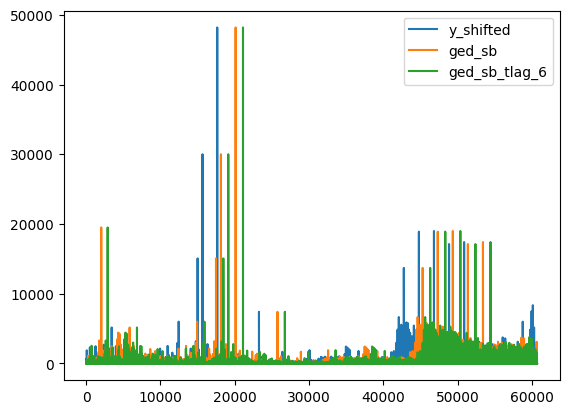

In [55]:
cm_features['y_shifted'] = cm_features.groupby('country_id')['ged_sb'].shift(-15)  # 3 months gap + 12 months prediction
# show na for y_shifted
cm_features[cm_features['y_shifted'].isna()]
# drop na
cm_features = cm_features.dropna()
# plot y_shifted per month
from matplotlib import pyplot as plt

cm_features['y_shifted'].plot()
cm_features['ged_sb'].plot()
cm_features['ged_sb_tlag_6'].plot()
plt.legend()
plt.show()

In [56]:
# drop all ged_sb_tlag_x except for the ged_sb_tlag_6
cm_features = cm_features.drop(columns=['country', 'gleditsch_ward'])
# drop if exists 'year', 'ccode', 'gw_statename'
cm_features = cm_features.drop(columns=['year', 'ccode', 'gw_statename'], errors='ignore')

# cm_features = cm_features.drop(
#     columns=['ged_sb_tlag_2', 'ged_sb_tlag_3', 'ged_sb_tlag_4', 'ged_sb_tlag_5', 'ged_sb_tlag_1', 'ged_sb_tlag_6', ])
# # drop ged_sb, ged_ns, ged_os, acled_sb, acled_sb_ count, acled_os, ged_sb_tsum_24
# cm_features = cm_features.drop(
#     columns=['ged_sb', 'ged_ns', 'ged_os', 'acled_sb', 'acled_sb_count', 'acled_os', 'ged_sb_tsum_24', 'ged_os_tlag_1'])
# # drop splag_1_decay_ged_sb_5, splag_1_decay_ged_os_5, splag_1_decay_ged_ns_5, decay_ged_sb_5, decay_ged_os_5, decay_ged_sb_500, decay_ged_os_100, decay_ged_ns_5, decay_ged_ns_100, decay_acled_sb_5, decay_acled_os_5, decay_acled_ns_5
# cm_features = cm_features.drop(
#     columns=['splag_1_decay_ged_sb_5', 'splag_1_decay_ged_os_5', 'splag_1_decay_ged_ns_5', 'decay_ged_sb_5',
#              'decay_ged_os_5', 'decay_ged_sb_500', 'decay_ged_os_100', 'decay_ged_ns_5', 'decay_ged_ns_100',
#              'decay_acled_sb_5', 'decay_acled_os_5', 'decay_acled_ns_5', 'decay_ged_sb_100'])



In [57]:
# save first 50 rows of the dataset to a new csv file with column names
# cm_features.head(50).to_csv('data/cm_features_first_50.csv', index=True)
# cm_features.head(10)
# prepare dataset for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm_features['date'] = pd.to_datetime(cm_features['date'])
cm_features['country_id'] = cm_features['country_id'].astype('category')
cm_features

,month_id,country_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,...,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,splag_1_decay_ged_sb_5,splag_1_decay_ged_os_5,splag_1_decay_ged_ns_5,date,y_shifted
0,121,1,0,0,0,0,0,0,0,752897,...,27.952694,1.380676,3.333333,315260.986388,354505.092577,0.093750,1.034032,0.093750,1990-01-01,0.0
1,121,2,0,0,0,0,0,0,0,408360,...,57.289771,3.922495,2.950609,264606.831667,264606.831667,0.062500,0.062500,0.062500,1990-01-01,0.0
2,121,3,0,0,0,0,0,0,0,1256210,...,35.755839,36.015231,17.956469,3244.939711,3244.939711,0.000000,0.000000,0.000000,1990-01-01,0.0
3,121,4,0,0,12,0,0,0,0,19275292,...,28.946372,26.864392,2.249173,45295.968642,74555.476336,1.062500,1.062500,0.093750,1990-01-01,0.0
4,121,7,0,0,0,0,0,0,0,32165766,...,51.887498,11.043387,7.800305,9511.721633,28542.982753,0.874154,0.156250,0.156250,1990-01-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60668,487,242,0,0,0,0,0,0,0,59872579,...,39.936434,6.594440,12.963241,1583.434859,1814.729450,4.569363,4.371473,2.248713,2020-07-01,0.0
60669,487,243,0,0,0,0,0,0,0,36304408,...,51.937737,7.966655,50.751212,825.592620,825.592620,0.911026,0.076540,0.093665,2020-07-01,0.0
60670,487,244,0,0,0,0,0,0,0,4383849,...,31.864675,3.627975,13.246217,96.072254,2738.059240,1.944327,1.130247,1.072989,2020-07-01,0.0
60671,487,245,3,107,12,10,1,50,176,43232093,...,52.712908,2.478948,118.656388,100.382863,948.618053,6.108470,4.948411,4.582199,2020-07-01,3.0


In [58]:
from sklearn.preprocessing import OneHotEncoder

# Define the split date


# features_to_exclude = ['id', 'country', 'ged_sb_tlag_6']
# features = [col for col in cm_features.columns if col not in features_to_exclude]

# X_train = train_df[features]
# y_train = train_df['ged_sb_tlag_6']
# X_test = test_df[features]
# y_test = test_df['ged_sb_tlag_6']
# 
# X_train[features]

In [59]:
# One-hot encode 'country_id'
INCLUDE_COUNTRY_ID = True
if INCLUDE_COUNTRY_ID:
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit_transform(cm_features[['country_id']])
    countries_encoded = encoder.transform(cm_features[['country_id']])
    # rename the columns
    countries_encoded = pd.DataFrame(countries_encoded, columns=encoder.get_feature_names_out(['country_id']))
    countries_encoded = countries_encoded.drop(columns='country_id_1')  # drop country_id_1
    # drop na 

    # countries_encoded
    # merge the encoded features with the original dataset
    cm_features = pd.concat([cm_features, countries_encoded], axis=1)
    cm_features = cm_features.dropna()
cm_features

/Users/zakotianskyi/Library/Caches/pypoetry/virtualenvs/my_project-FBv7emLR-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,month_id,country_id,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,...,country_id_231,country_id_233,country_id_234,country_id_235,country_id_237,country_id_242,country_id_243,country_id_244,country_id_245,country_id_246
0,121.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,752897.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,121.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408360.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,121.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1256210.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,121.0,4,0.0,0.0,12.0,0.0,0.0,0.0,0.0,19275292.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,121.0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32165766.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59874,483.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10698683.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59875,483.0,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18513673.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59876,483.0,64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5347896.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59877,483.0,65,2.0,0.0,0.0,0.0,0.0,0.0,50.0,144406261.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [60]:
# Split the dataset into training and test sets
# prediction_year = 2018
# test(final model evaluation): Jan 2018 - Jan 2019
# oct 2016 predicts Jan 2018
# oct 2017 predicts Jan 2019
# thus train set is up until Oct 2016
cut_year = prediction_year - 2  # 2016

features_to_oct = pd.Timestamp(year=cut_year, month=10, day=1)  # 2016-Oct-01

# Splitting the dataset
train_df = cm_features[cm_features['date'] < features_to_oct]
# test_df is one year from Oct 2016 to Oct 2017
test_df = cm_features[
    (cm_features['date'] >= pd.Timestamp(year=prediction_year - 2, month=10, day=1)) &  # oct 2016 predicts Jan 2018
    (cm_features['date'] < pd.Timestamp(year=prediction_year - 1, month=10, day=1))]  # oct 2017 predicts Jan 2019
# remove date column

# save date column for test_df
test_df_date = test_df['date']
train_df_date = train_df['date']
train_df_country_id = train_df['country_id']
test_df_country_id = test_df['country_id']
train_df_month_id = train_df['month_id']
test_df_month_id = test_df['month_id']

test_df = test_df.drop('date', axis=1)
test_df = test_df.drop("country_id", axis=1)

train_df = train_df.drop('date', axis=1)
train_df = train_df.drop("country_id", axis=1)

test_df = test_df.drop('month_id', axis=1)
train_df = train_df.drop('month_id', axis=1)
test_df

,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,country_id_231,country_id_233,country_id_234,country_id_235,country_id_237,country_id_242,country_id_243,country_id_244,country_id_245,country_id_246
52899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,755031.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575475.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1460177.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52902,0.0,0.0,2.0,0.0,0.0,0.0,0.0,30529716.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43131966.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54922,0.0,0.0,0.0,0.0,0.0,3.0,0.0,54401802.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54923,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35107264.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4051890.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54925,19.0,0.0,9.0,22.0,6.0,29.0,1551.0,39377169.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
target = 'y_shifted'
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [62]:
y_train

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
52894     0.0
52895     0.0
52896     0.0
52897     4.0
52898    62.0
Name: y_shifted, Length: 52105, dtype: float64

In [63]:
# assert month_id, country_id, date are not in the features
# assert 'month_id' not in X_train.columns
X_test

,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,country_id_231,country_id_233,country_id_234,country_id_235,country_id_237,country_id_242,country_id_243,country_id_244,country_id_245,country_id_246
52899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,755031.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575475.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1460177.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52902,0.0,0.0,2.0,0.0,0.0,0.0,0.0,30529716.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43131966.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54922,0.0,0.0,0.0,0.0,0.0,3.0,0.0,54401802.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54923,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35107264.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4051890.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54925,19.0,0.0,9.0,22.0,6.0,29.0,1551.0,39377169.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
import xgboost as xgb

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test, label=y_test)

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Specify parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    # 'objective': 'count:poisson',
    'eval_metric': 'rmse',
    # 'eval_metric': 'poisson-nloglik',
    'learning_rate': 0.1,
}

# Train the model
num_round = 40
bst = xgb.train(params, dtrain, num_round)

# Make predictions
train_predictions = bst.predict(dtrain)
predictions = bst.predict(dtest)
# Discard all negative predictions and set them to 0. This is because the target variable is non-negative
# and following the ViEWS technical report they use GAM that converts negative predictions to 0 and then almost linear
predictions = [max(0, pred) for pred in predictions]

In [65]:
# map predictions to months based on the test_df
test_df['predictions'] = predictions
train_df['predictions'] = train_predictions
# add date column back to test_df and add to each date shift of 15 months
test_df['date'] = test_df_date + pd.DateOffset(months=15)
train_df['date'] = train_df_date
test_df['country_id'] = test_df_country_id
train_df['country_id'] = train_df_country_id
test_df['month_id'] = test_df_month_id
train_df['month_id'] = train_df_month_id
test_df

,ged_sb,ged_ns,ged_os,acled_sb,acled_sb_count,acled_os,ged_sb_tsum_24,wdi_sp_pop_totl,ged_sb_tlag_1,ged_sb_tlag_2,...,country_id_237,country_id_242,country_id_243,country_id_244,country_id_245,country_id_246,predictions,date,country_id,month_id
52899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,755031.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-01-01,1,442.0
52900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575475.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-01-01,2,442.0
52901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1460177.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-01-01,3,442.0
52902,0.0,0.0,2.0,0.0,0.0,0.0,0.0,30529716.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-01-01,4,442.0
52903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43131966.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-01-01,7,442.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54922,0.0,0.0,0.0,0.0,0.0,3.0,0.0,54401802.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-12-01,242,453.0
54923,0.0,0.0,0.0,0.0,1.0,0.0,0.0,35107264.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.156420,2018-12-01,243,453.0
54924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4051890.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.410955,2018-12-01,244,453.0
54925,19.0,0.0,9.0,22.0,6.0,29.0,1551.0,39377169.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,77.828102,2018-12-01,245,453.0


In [66]:
# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
rmse = sqrt(mean_squared_error(y_test, predictions))
# actuals_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], predictions))
# benchmark_rmse = sqrt(mean_squared_error(y_test, benchmark_model['outcome']))
actuals_bench_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], benchmark_model['outcome']))

# TODO: Improve metrics and use all metrics from the VIEWS competition
# Output RMSE
print(f"[train predictions] RMSE: {train_rmse}")
print(f"[test predictions]  RMSE YTEST VS PREDICTIONS: {rmse}")
# print(f"RMSE YTEST VS ACTUALS: {actuals_rmse}")
# print(f"RMSE YTEST VS BENCHMARK: {benchmark_rmse}")
print(f"RMSE ACTUALS VS BENCHMARK: {actuals_bench_rmse}")

[train predictions] RMSE: 126.60365404130044
[test predictions]  RMSE YTEST VS PREDICTIONS: 138.58069275478246
RMSE ACTUALS VS BENCHMARK: 188.86519776522132


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

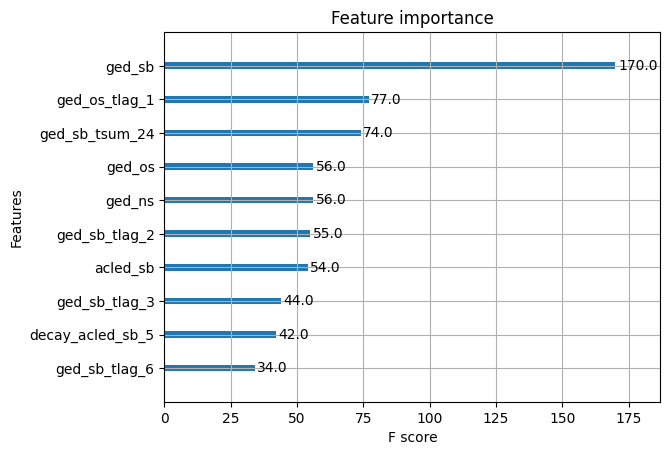

In [67]:
from xgboost import plot_importance

# plot
plot_importance(bst, max_num_features=10)


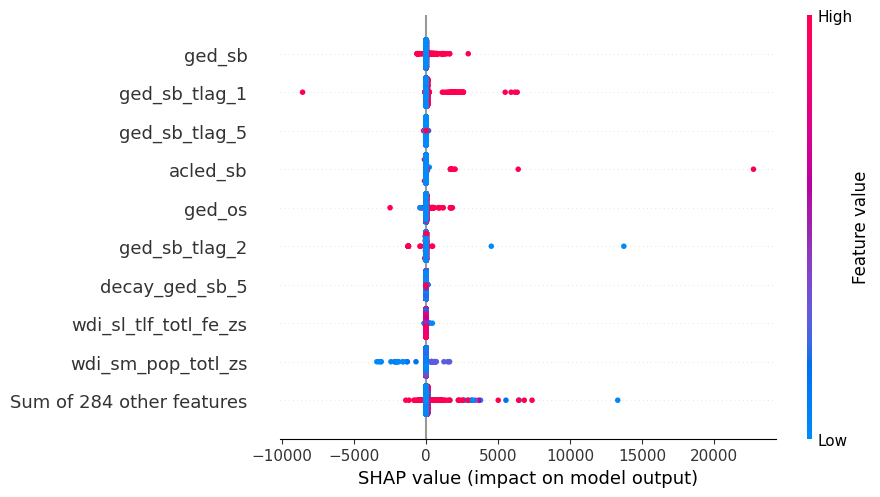

In [68]:
import shap

explainer = shap.TreeExplainer(bst)
# dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.feature_names = X_train.columns.tolist()
explanation = explainer(dtrain)
explanation = shap.Explanation(
    values=explanation.values,
    base_values=explanation.base_values,
    data=explanation.data,
    feature_names=X_train.columns.tolist()
)
shap.plots.beeswarm(explanation)


In [69]:
# shap.force_plot(explainer.expected_value, explanation[0, :], X_train.iloc[0,:])
# X_train.iloc[0,:]
# X_train
# shap.summary_plot(explainer, X_train, plot_type="bar")

In [70]:
# print all feature importance sorted
feature_importance = bst.get_fscore()
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
feature_importance

[('ged_sb', 170.0),
 ('ged_os_tlag_1', 77.0),
 ('ged_sb_tsum_24', 74.0),
 ('ged_ns', 56.0),
 ('ged_os', 56.0),
 ('ged_sb_tlag_2', 55.0),
 ('acled_sb', 54.0),
 ('ged_sb_tlag_3', 44.0),
 ('decay_acled_sb_5', 42.0),
 ('ged_sb_tlag_6', 34.0),
 ('ged_sb_tlag_1', 33.0),
 ('decay_ged_sb_100', 32.0),
 ('splag_1_decay_ged_os_5', 32.0),
 ('country_id_87', 31.0),
 ('acled_sb_count', 24.0),
 ('wdi_sm_pop_totl_zs', 24.0),
 ('ged_sb_tlag_5', 23.0),
 ('wdi_sp_pop_totl', 22.0),
 ('acled_os', 19.0),
 ('wdi_sm_pop_refg_or', 18.0),
 ('wdi_sp_dyn_imrt_in', 17.0),
 ('country_id_131', 17.0),
 ('decay_ged_ns_5', 16.0),
 ('ged_sb_tlag_4', 15.0),
 ('wdi_sl_tlf_totl_fe_zs', 15.0),
 ('wdi_sp_dyn_le00_in', 14.0),
 ('country_id_165', 14.0),
 ('decay_ged_sb_500', 13.0),
 ('decay_ged_ns_100', 13.0),
 ('decay_acled_os_5', 13.0),
 ('splag_1_decay_ged_sb_5', 13.0),
 ('splag_1_decay_ged_ns_5', 13.0),
 ('vdem_v2clrgunev', 12.0),
 ('decay_ged_os_100', 11.0),
 ('country_id_64', 11.0),
 ('vdem_v2xcl_dmove', 10.0),
 ('wdi_sp

In [71]:
# for each timeseries plot the actual and predicted values
import matplotlib.pyplot as plt
# map back id to country name
# country_id = index + 1
# y_test.reset_index(inplace=True, drop=True)
# y_test = y_test.to_frame()
# y_test['country_id'] = y_test.index + 1



In [72]:
# map country_id to country name
# country_list = pd.read_csv('data/country_list.csv') 
# country_list
# y_test["country_name"] = y_test["country_id"].map(country_list.set_index('country_id')['name'])
# y_test

Unique months: [442. 443. 444. 445. 446. 447. 448. 449. 450. 451. 452. 453.]


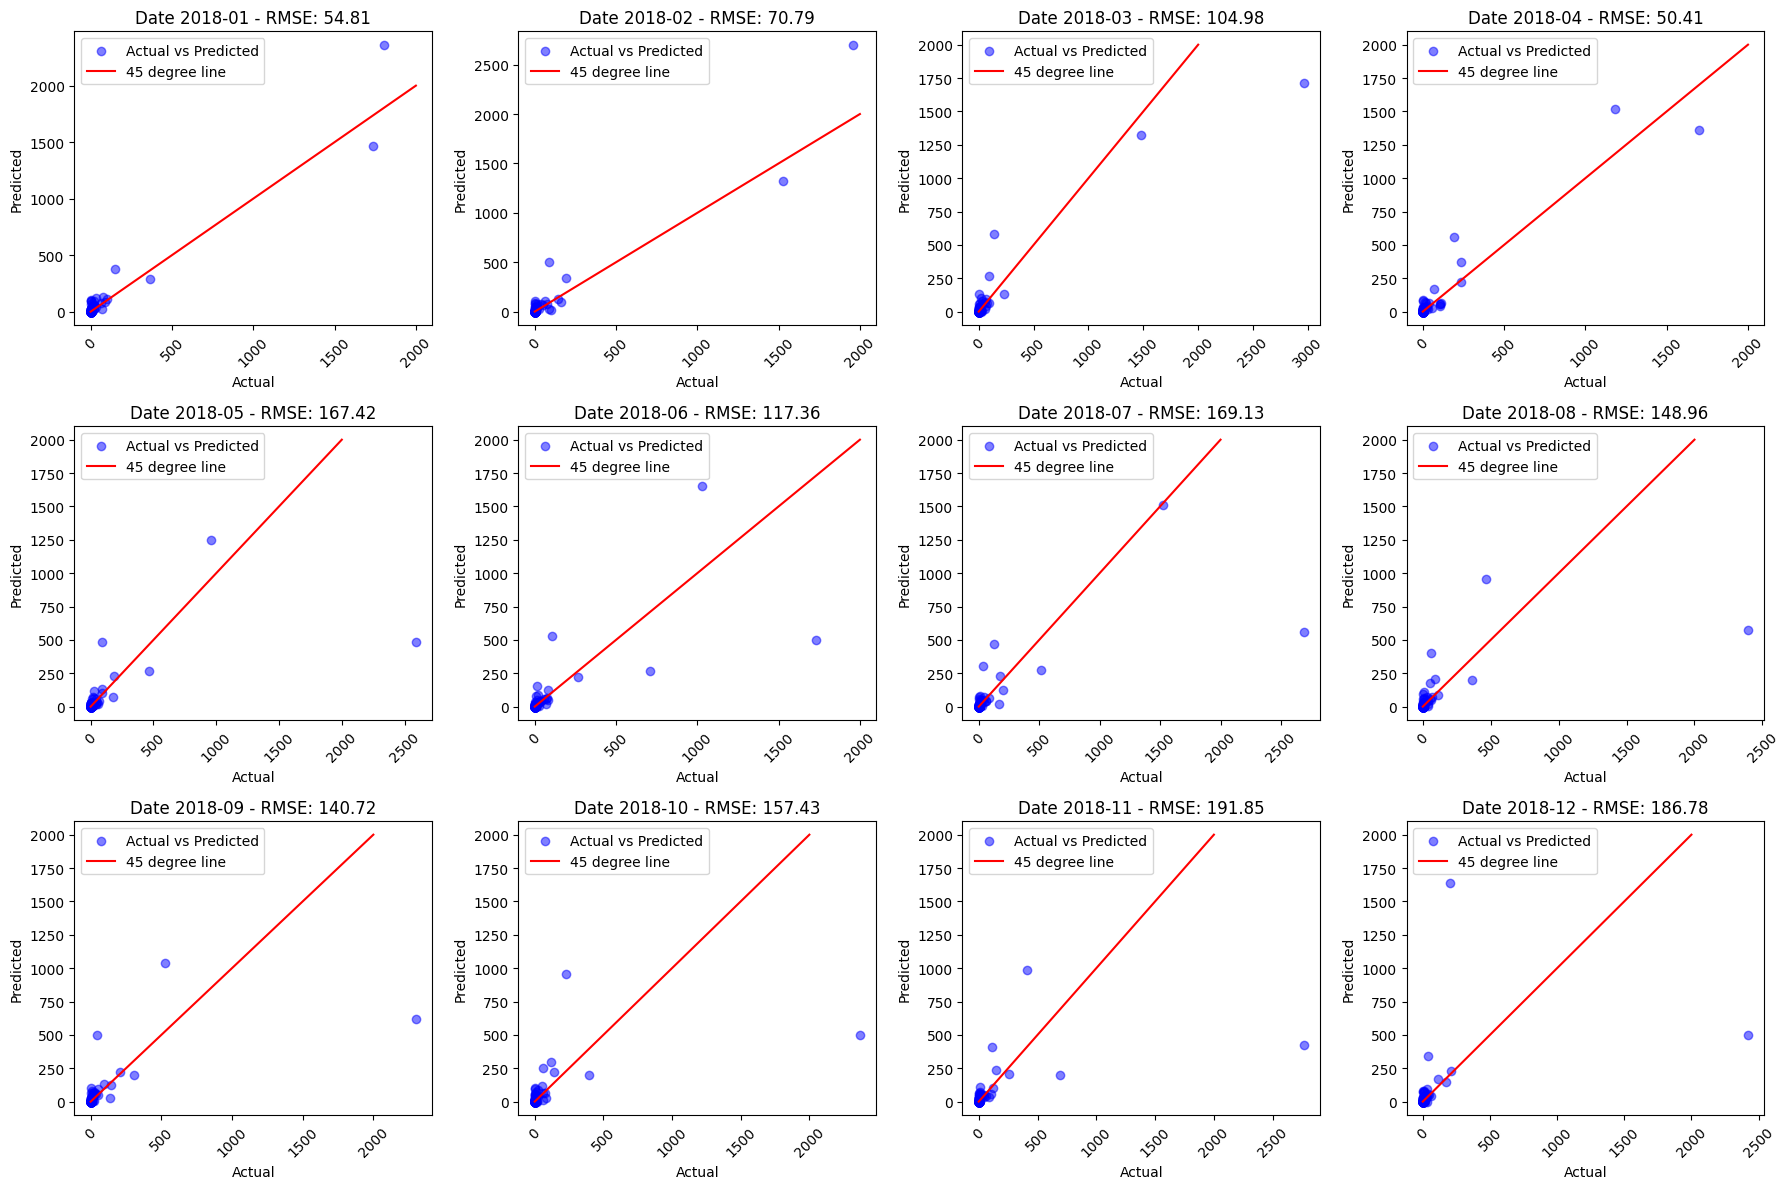

In [73]:
# get all unique months sorted from test_df
# test_df['month_id'].unique()
# # get target and predictions for each month
# for month_id in test_df['month_id'].unique():
#     # get target and predictions for each month
#     target_month = test_df[test_df['month_id'] == month_id][target]
#     predictions_month = test_df[test_df['month_id'] == month_id]['predictions']
#     # plot actual vs predicted for each month
#     plt.figure(figsize=(10, 6))
#     plt.scatter(target_month, predictions_month, color='blue', label='Actual', alpha=0.5)
#     plt.title(f'Actual vs Predicted Values for month {month_id}')
#     plt.xlabel('Actual')
#     plt.ylabel('Predicted')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.plot([0, 1000], [0, 1000], color='red', label='45 degree line')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.show()

import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame, and 'target' and 'predictions' are columns in it
unique_months = test_df['month_id'].unique()
n_months = len(unique_months)
print("Unique months:", unique_months)

# Calculate the grid size for the subplot (simple square root approximation for a square grid)
grid_size_x = int(n_months ** 0.5) + (1 if n_months % int(n_months ** 0.5) else 0)
grid_size_y = grid_size_x + 1

# print(f'Grid size: {grid_size}')
# Set overall figure size
plt.figure(figsize=(grid_size_x * 6, grid_size_y * 3))  # Adjust the size factors (6, 4) based on your preference

for index, month_id in enumerate(unique_months, start=1):
    this_month = test_df[test_df['month_id'] == month_id]
    mean_sq_error = sqrt(mean_squared_error(this_month[target], this_month['predictions']))
    current_date = this_month["date"].iloc[0]
    target_month = this_month[target]
    predictions_month = this_month['predictions']

    # Create subplot for current month
    plt.subplot(grid_size_x, grid_size_y, index)
    plt.scatter(target_month, predictions_month, color='blue', label='Actual vs Predicted', alpha=0.5)
    # print current_date in YY/MM format
    print_date = current_date.strftime('%Y-%m')
    plt.title(f'Date {print_date} - RMSE: {mean_sq_error:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.plot([0, 2000], [0, 2000], color='red', label='45 degree line')
    plt.legend()
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [74]:
# plot series of actual vs predicted for each country
# country_ids = test_df['country_id'].unique().tolist()[:1]
# # remove country id if it 
# 
# 
# for country_id in country_ids:
#     # get target and predictions for each country
#     this_country = test_df[test_df['country_id'] == country_id]
#     # this_country.reset_index(inplace=True, drop=True)
#     target_country = this_country[target]
#     predictions_country = this_country['predictions']
#     # plot actual vs predicted for each country
#     plt.figure(figsize=(10, 6))
#     # plot train set actual
#     plt.plot(train_df[train_df['country_id'] == country_id]['y_shifted'], label='Train', color='green')
# 
#     plt.plot(target_country, label='Actual', color='blue')
#     plt.plot(predictions_country, label='Predicted', color='red')
#     # set x as date according to the month_id
#     # plt.xticks(cm_features[cm_features['country_id'] == country_id]['month_id'], cm_features[cm_features['country_id'] == country_id]['date'], rotation=45)
#     plt.xlabel('date')
#     plt.ylabel('Ged_sb')
#     plt.legend()
#     # plt.xlim(0, len(this_country['date']))
#     plt.title(f'Actual vs Predicted Values for country {country_id}')
#     plt.show()


Skipping Guyana as all actuals are 0
Skipping Suriname as all actuals are 0
Skipping Trinidad and Tobago as all actuals are 0
Skipping Venezuela as all actuals are 0
Skipping Argentina as all actuals are 0
Skipping Bolivia as all actuals are 0
Skipping Brazil as all actuals are 0
Skipping Chile as all actuals are 0
Skipping Ecuador as all actuals are 0
Skipping Paraguay as all actuals are 0
Skipping Peru as all actuals are 0
Skipping Uruguay as all actuals are 0
Skipping Guatemala as all actuals are 0
Skipping Mexico as all actuals are 0
Skipping Barbados as all actuals are 0
Skipping Dominican Republic as all actuals are 0
Skipping Haiti as all actuals are 0
Skipping Jamaica as all actuals are 0


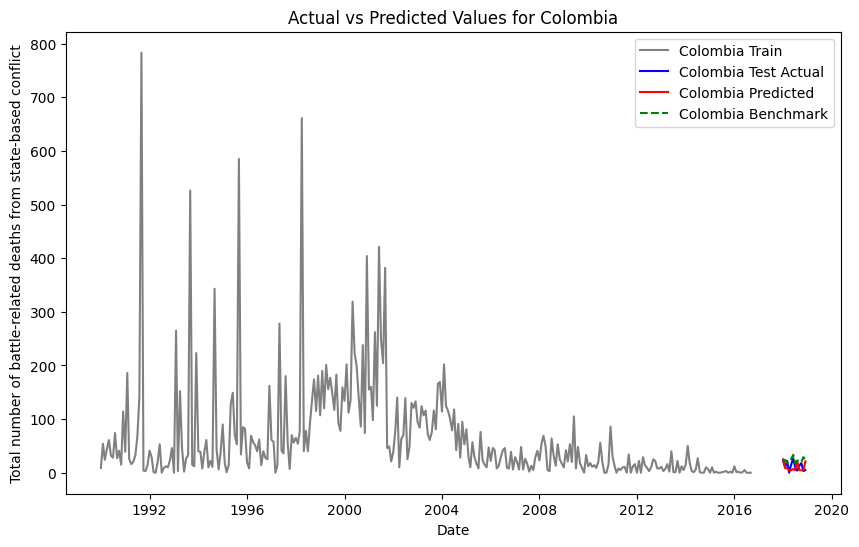

Skipping Costa Rica as all actuals are 0
Skipping Cuba as all actuals are 0
Skipping El Salvador as all actuals are 0
Skipping Honduras as all actuals are 0
Skipping Nicaragua as all actuals are 0
Skipping Panama as all actuals are 0
Skipping Iceland as all actuals are 0
Skipping Ireland as all actuals are 0
Skipping United Kingdom as all actuals are 0
Skipping Cape Verde as all actuals are 0
Skipping Cote d'Ivoire as all actuals are 0
Skipping Ghana as all actuals are 0
Skipping Liberia as all actuals are 0
Skipping Portugal as all actuals are 0
Skipping Spain as all actuals are 0


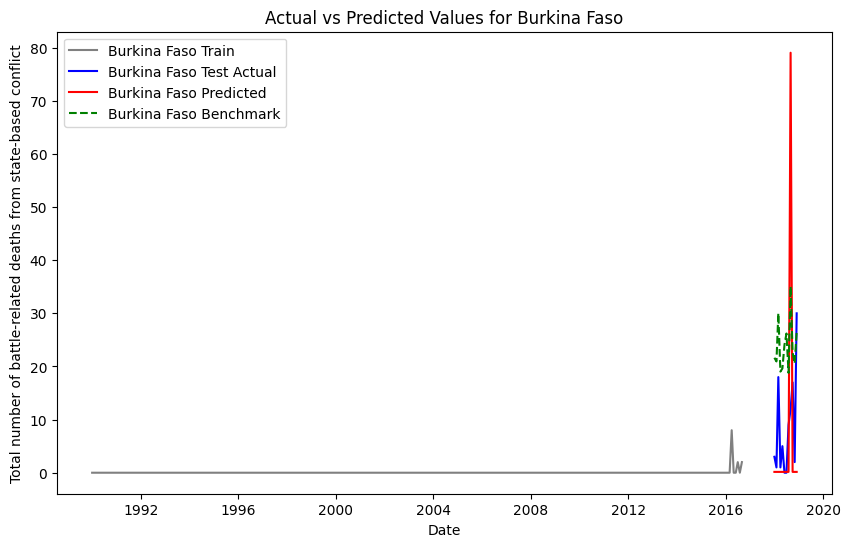

Skipping Guinea as all actuals are 0
Skipping Guinea-Bissau as all actuals are 0


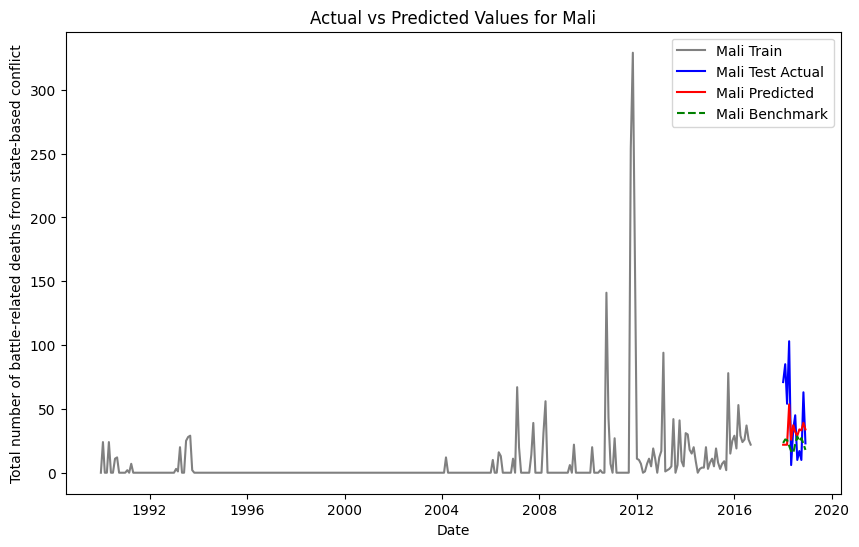

Skipping Senegal as all actuals are 0
Skipping Sierra Leone as all actuals are 0
Skipping The Gambia as all actuals are 0
Skipping Djibouti as all actuals are 0
Skipping Eritrea as all actuals are 0


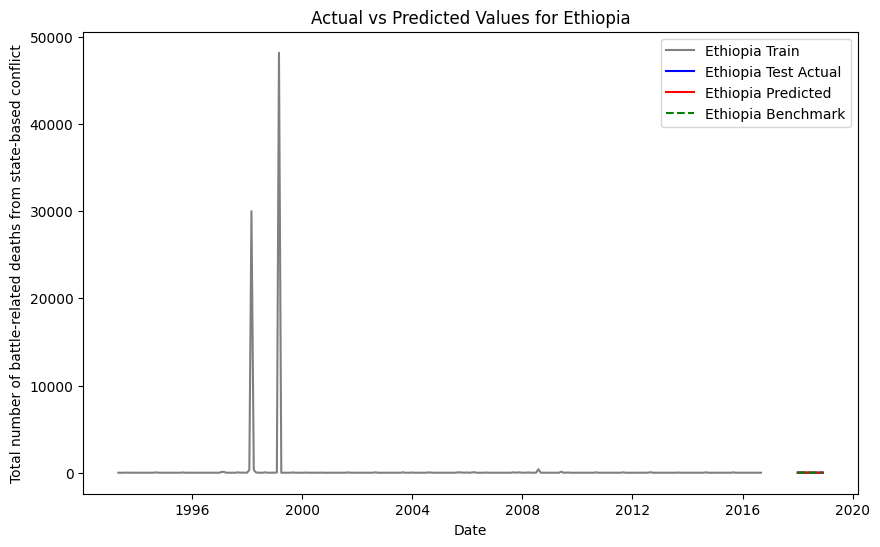

Skipping Mongolia as all actuals are 0


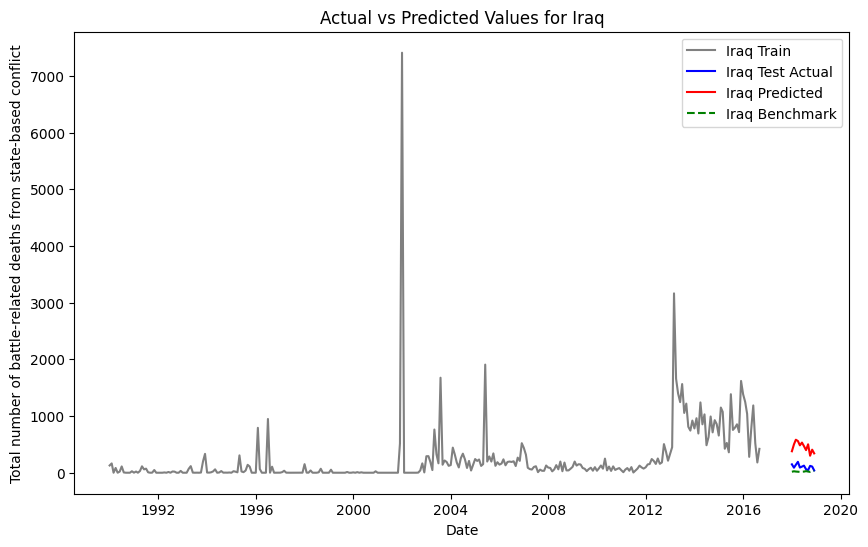

Skipping Jordan as all actuals are 0
Skipping Kazakhstan as all actuals are 0
Skipping Norway as all actuals are 0


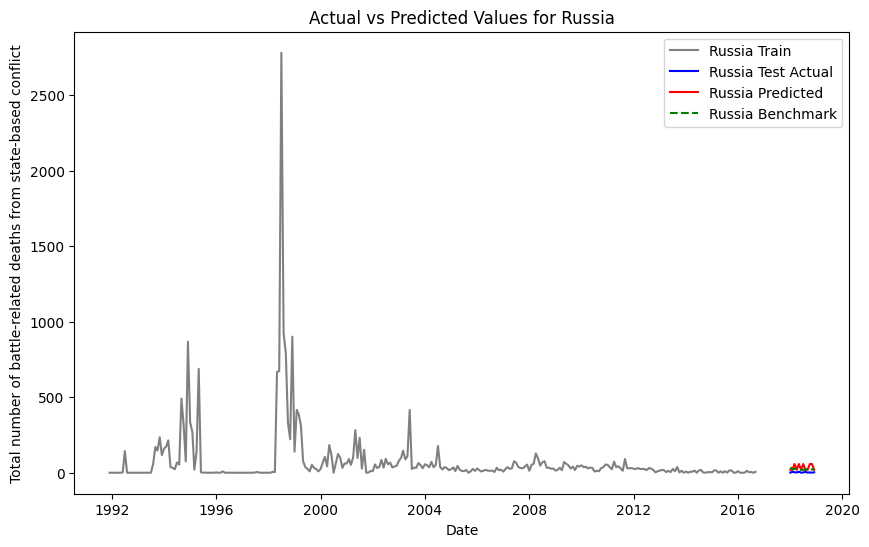

Skipping Sweden as all actuals are 0


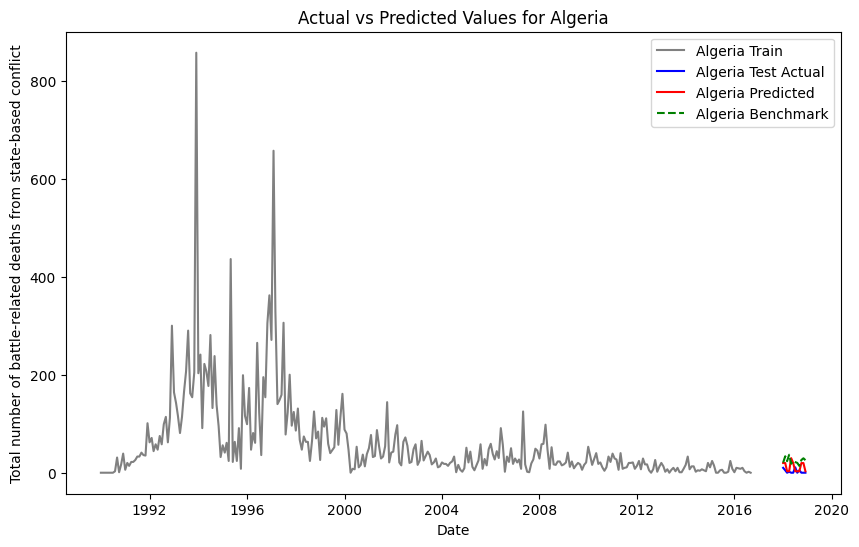

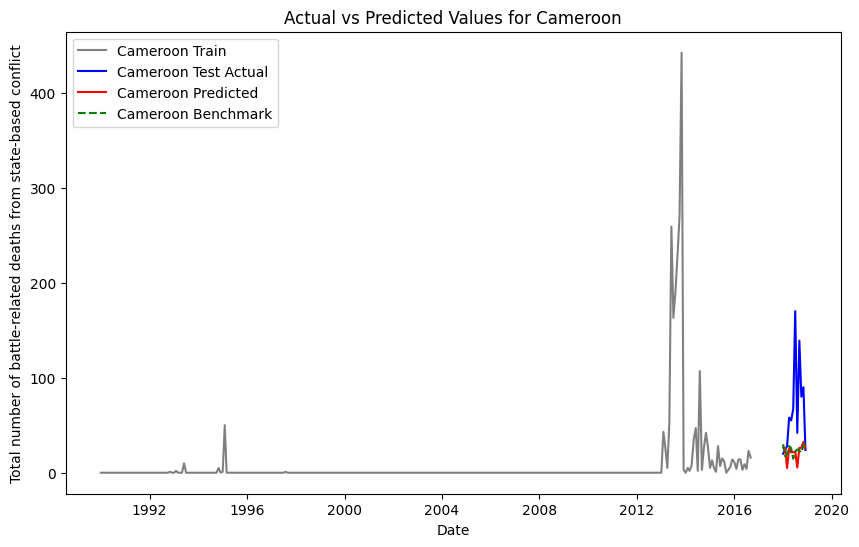

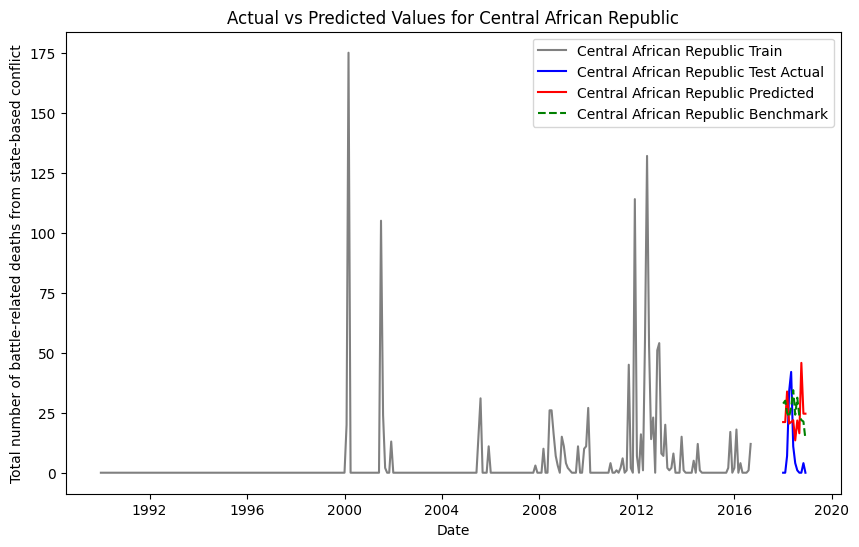

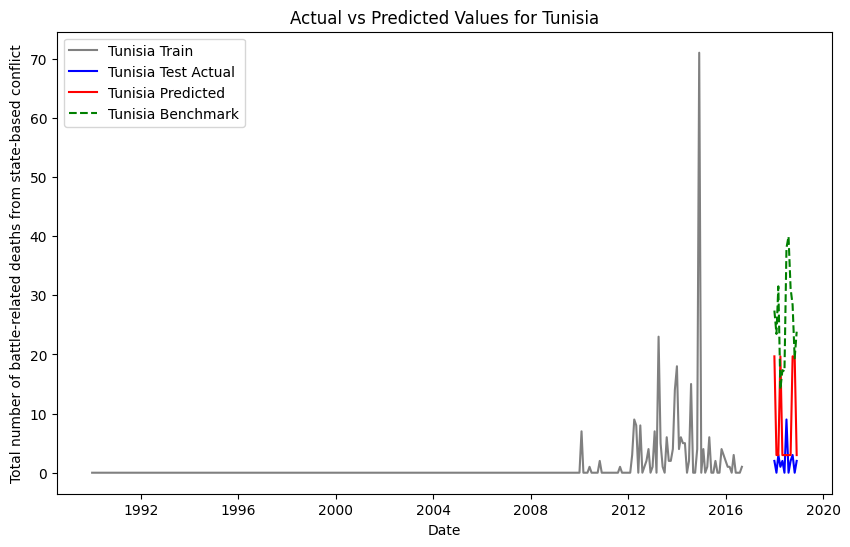

Skipping Benin as all actuals are 0
Skipping Equatorial Guinea as all actuals are 0


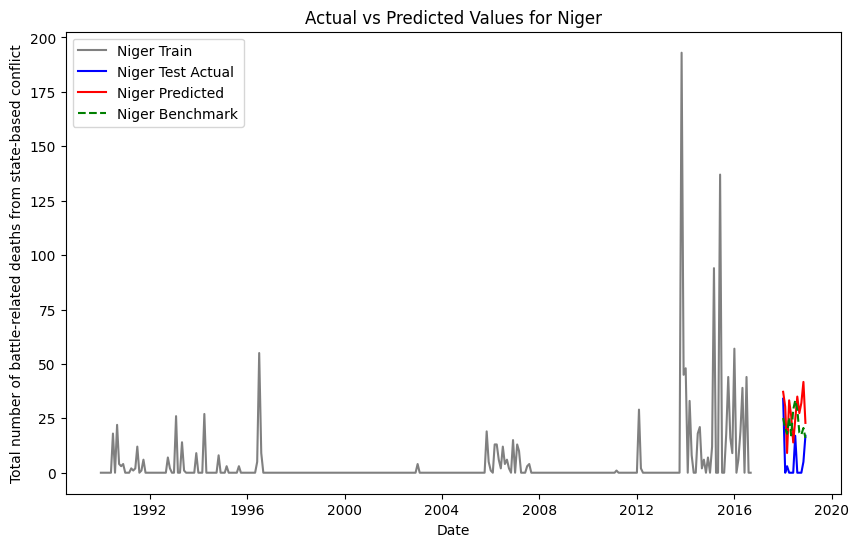

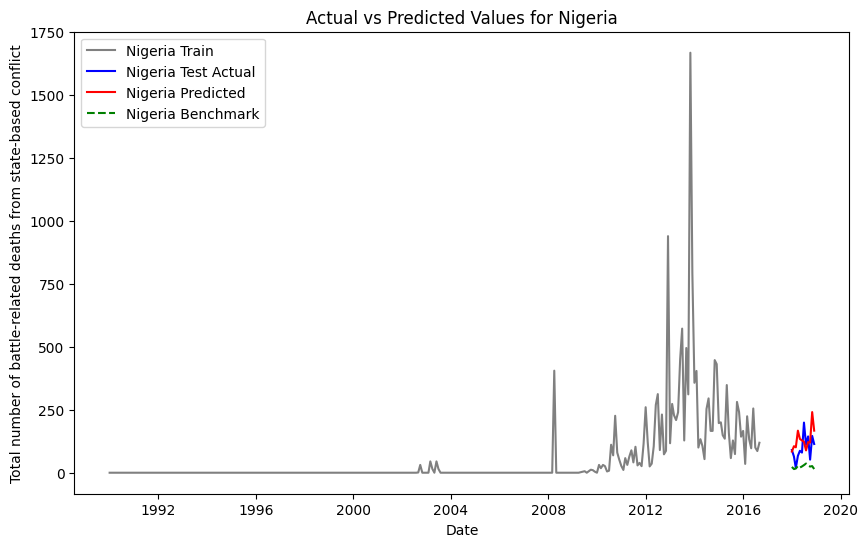

Skipping Togo as all actuals are 0
Skipping Albania as all actuals are 0
Skipping Bosnia and Herzegovina as all actuals are 0
Skipping Croatia as all actuals are 0
Skipping Italy as all actuals are 0
Skipping Macedonia as all actuals are 0
Skipping Malta as all actuals are 0
Skipping Bulgaria as all actuals are 0
Skipping Cyprus as all actuals are 0
Skipping Georgia as all actuals are 0
Skipping Greece as all actuals are 0


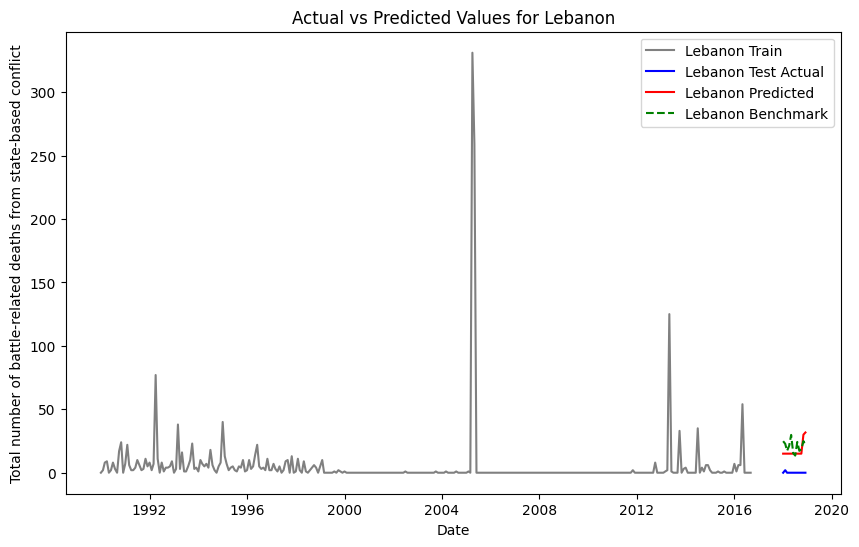

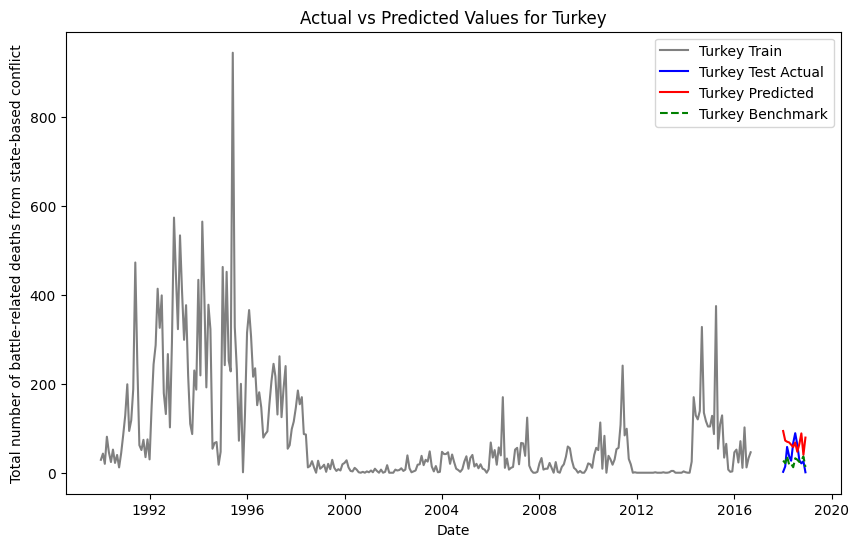

Skipping Austria as all actuals are 0
Skipping Czech Republic as all actuals are 0
Skipping Denmark as all actuals are 0
Skipping Hungary as all actuals are 0
Skipping Poland as all actuals are 0
Skipping Slovakia as all actuals are 0
Skipping Slovenia as all actuals are 0


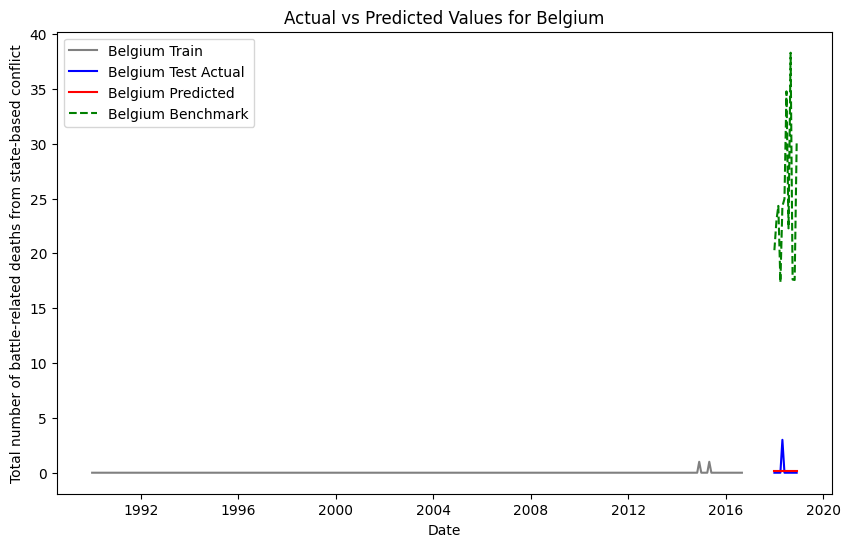

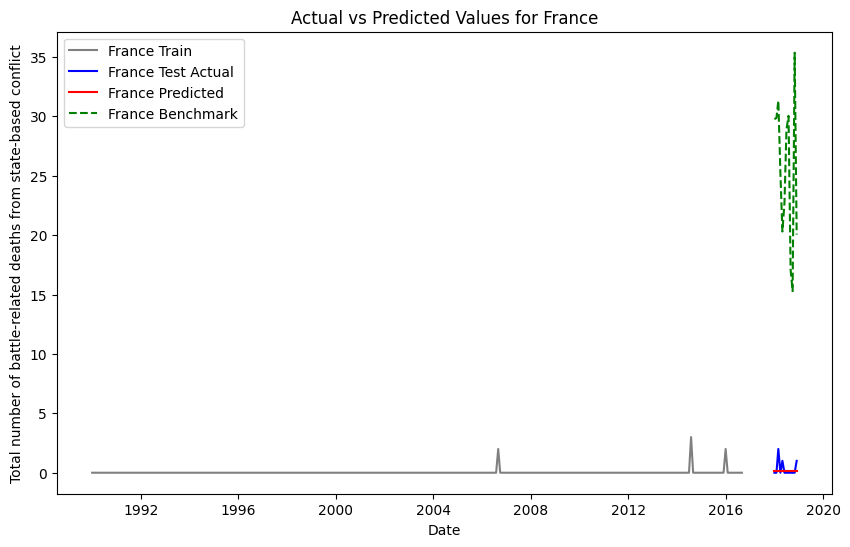

Skipping Luxembourg as all actuals are 0
Skipping Netherlands as all actuals are 0
Skipping Switzerland as all actuals are 0
Skipping Belarus as all actuals are 0
Skipping Estonia as all actuals are 0
Skipping Finland as all actuals are 0
Skipping Latvia as all actuals are 0
Skipping Lithuania as all actuals are 0
Skipping Moldova as all actuals are 0
Skipping Romania as all actuals are 0


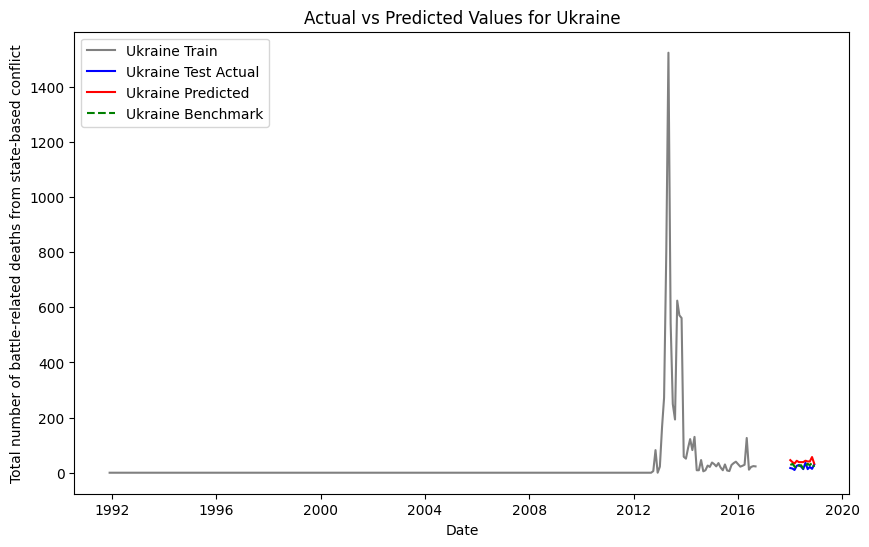

Skipping Maldives as all actuals are 0
Skipping Oman as all actuals are 0


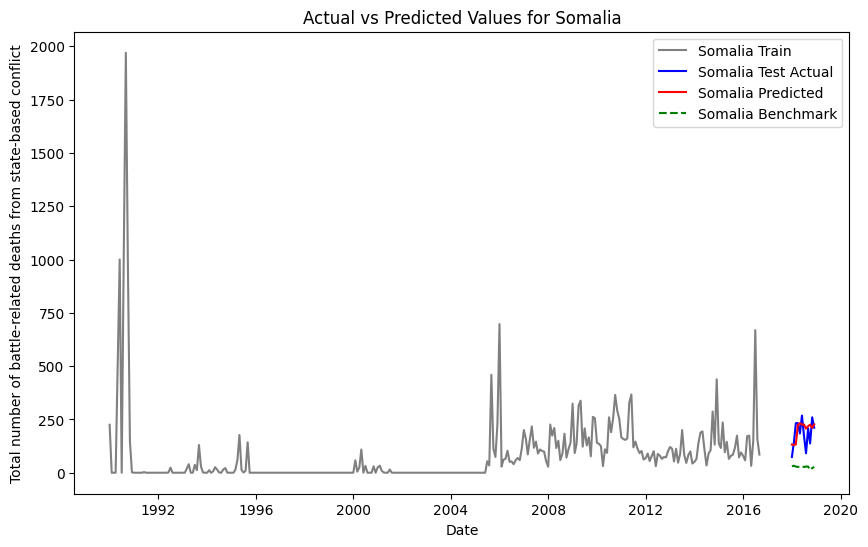

Skipping Sri Lanka as all actuals are 0
Skipping Turkmenistan as all actuals are 0
Skipping Uzbekistan as all actuals are 0


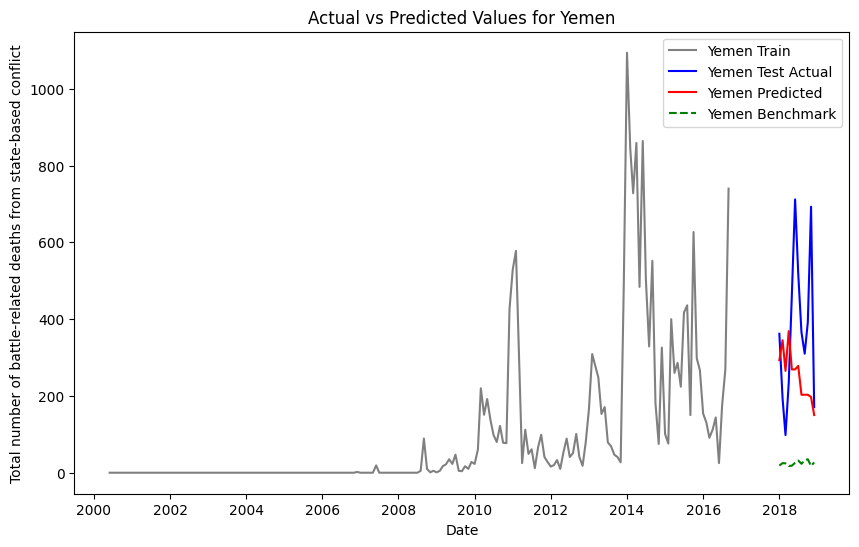

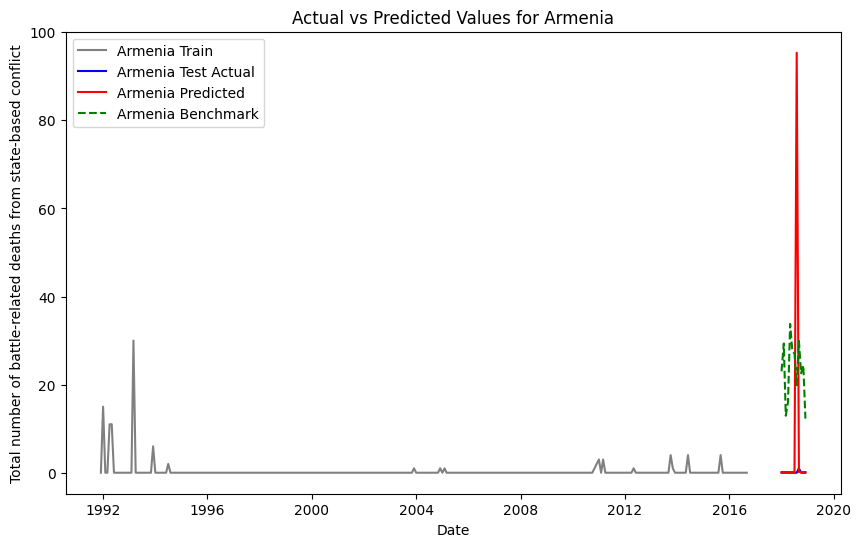

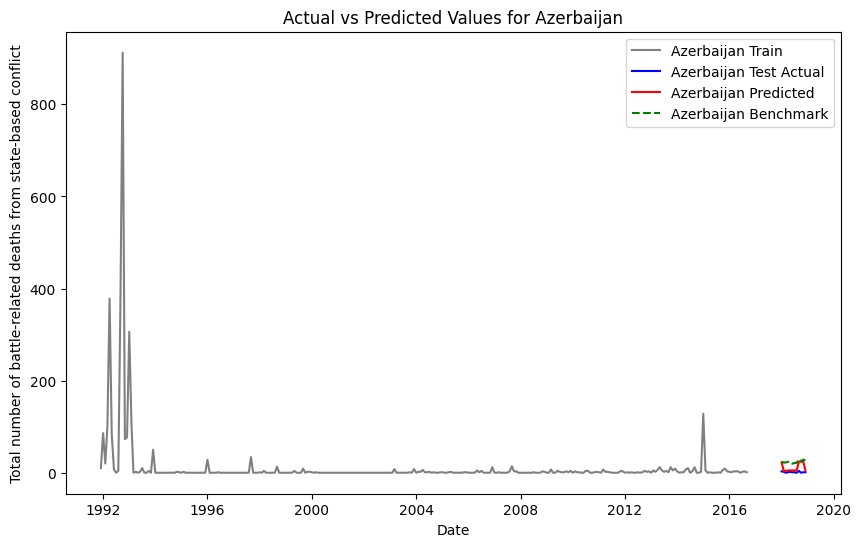

Skipping Bahrain as all actuals are 0


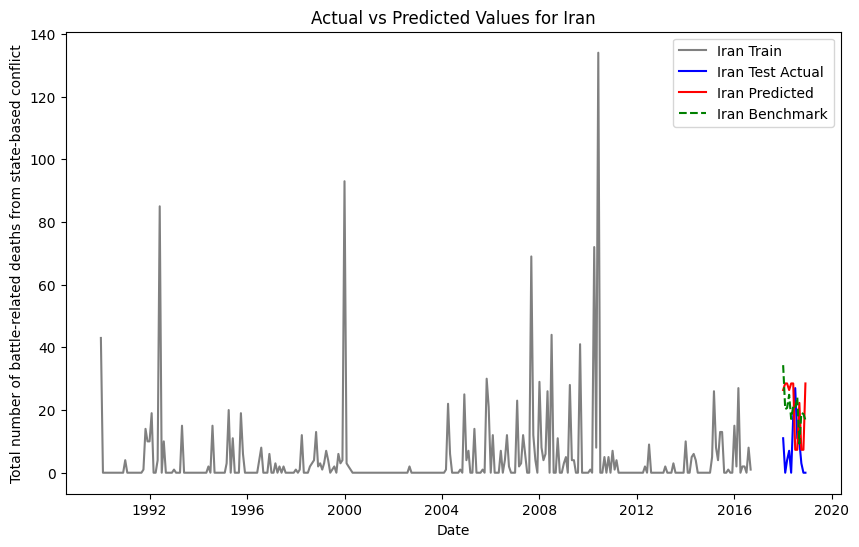

Skipping Kuwait as all actuals are 0
Skipping Qatar as all actuals are 0


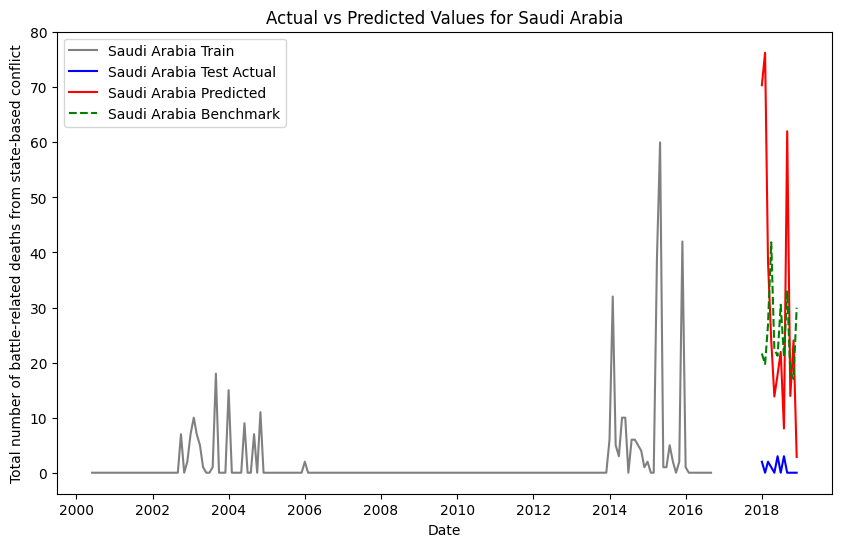

Skipping United Arab Emirates as all actuals are 0


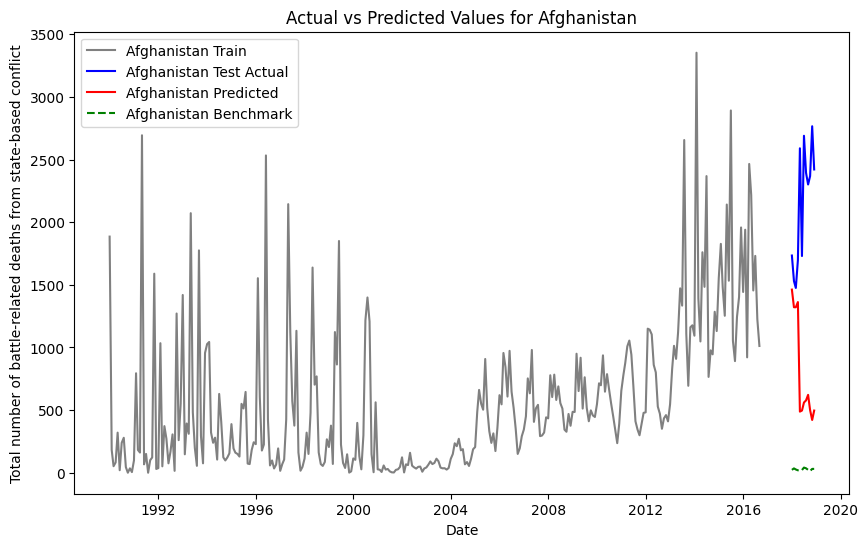

Skipping Kyrgyzstan as all actuals are 0
Skipping Nepal as all actuals are 0


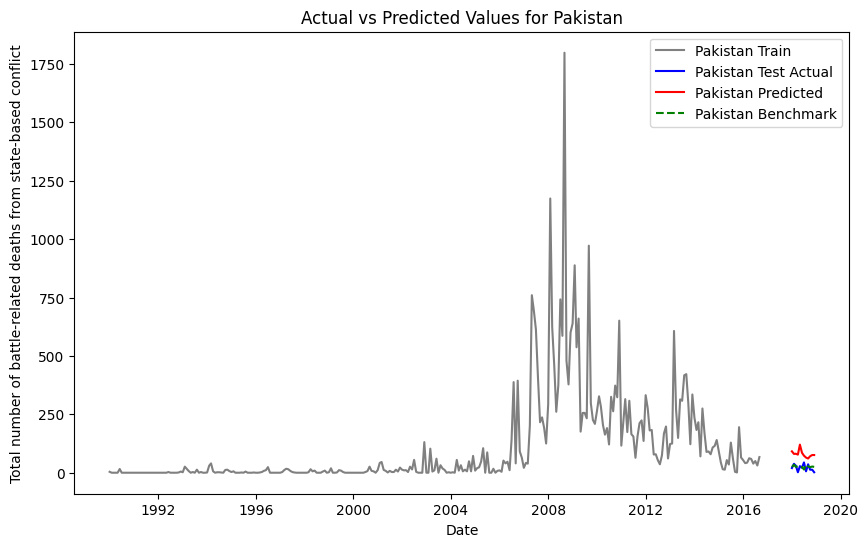

Skipping Tajikistan as all actuals are 0


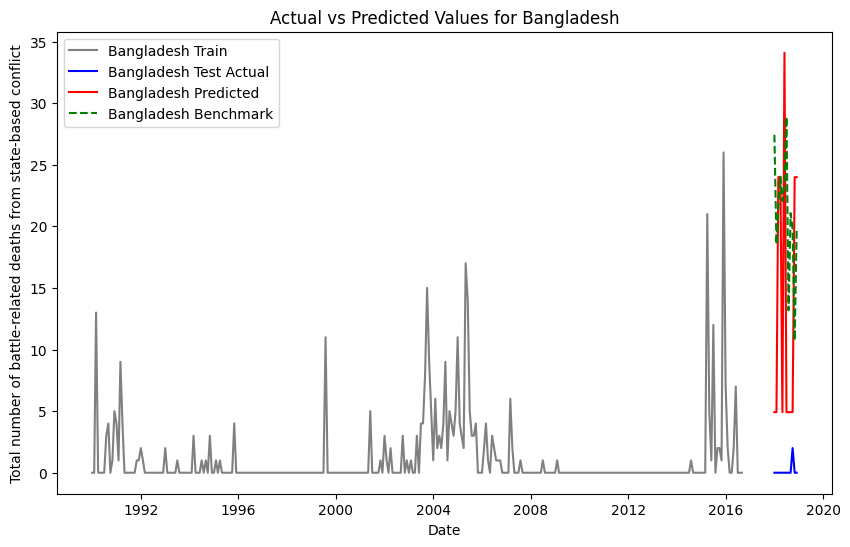

Skipping Bhutan as all actuals are 0
Skipping Japan as all actuals are 0
Skipping North Korea as all actuals are 0


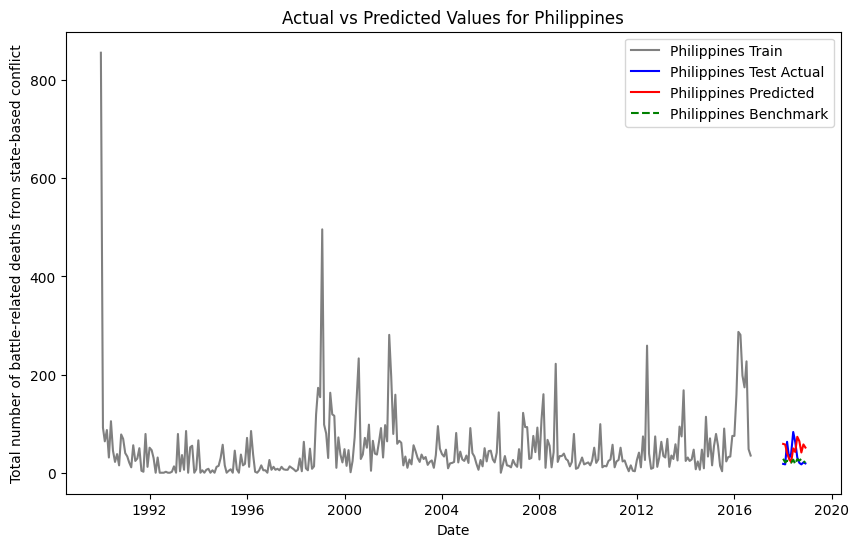

Skipping South Korea as all actuals are 0
Skipping Cambodia as all actuals are 0
Skipping Laos as all actuals are 0


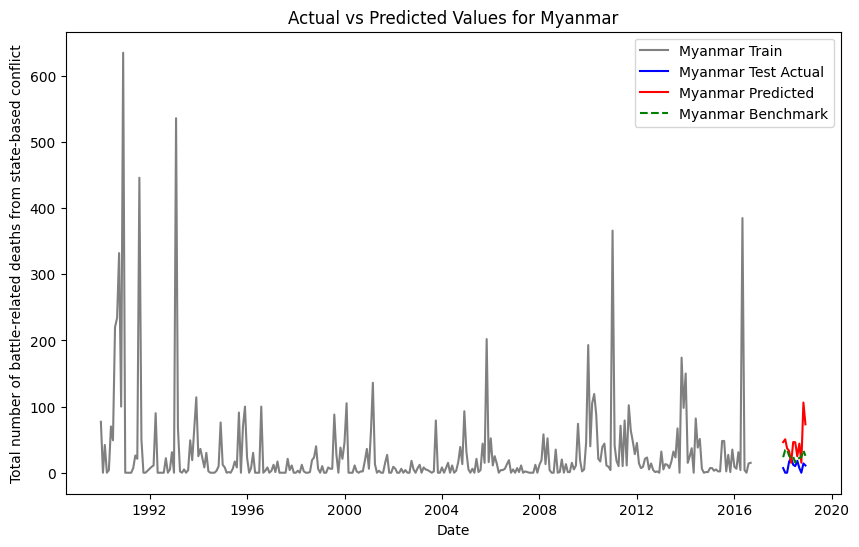

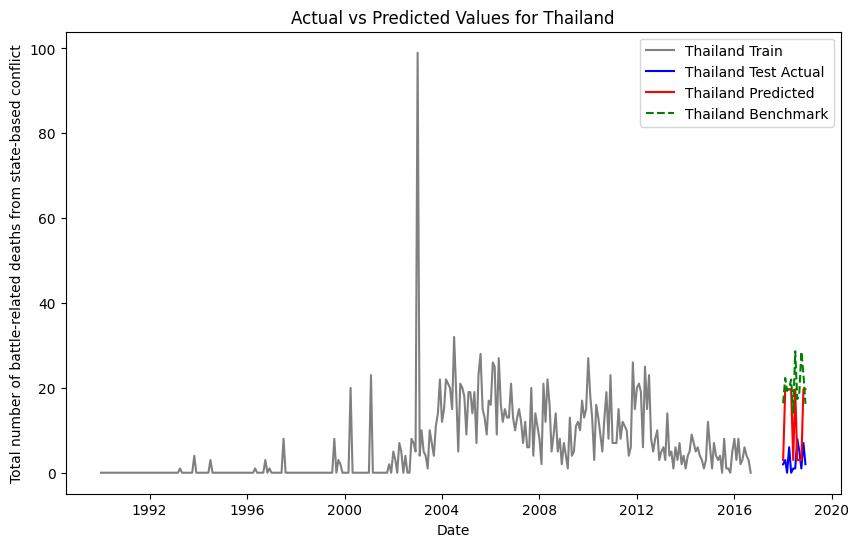

Skipping Vietnam as all actuals are 0
Skipping Botswana as all actuals are 0


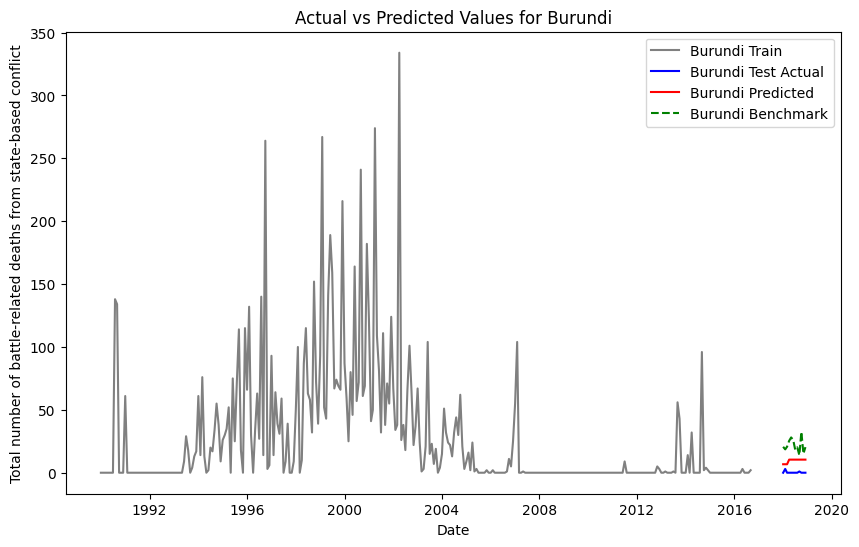

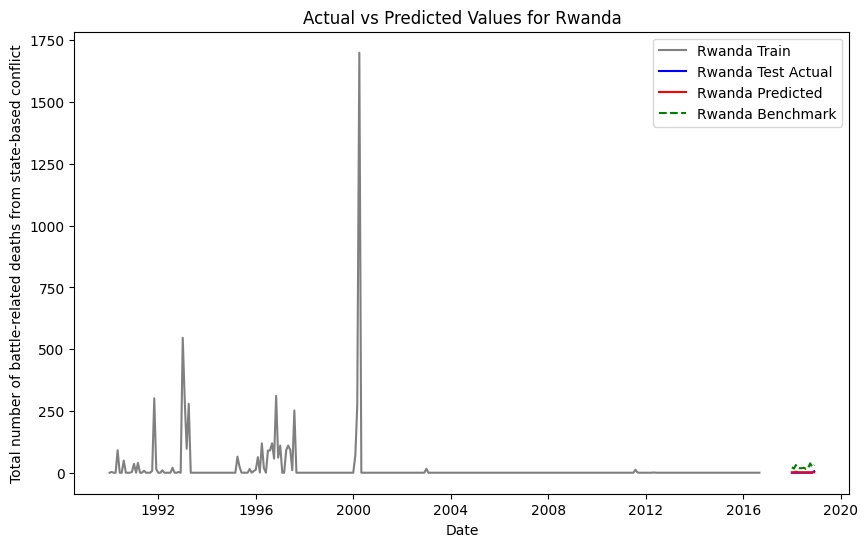

Skipping Zambia as all actuals are 0
Skipping Zimbabwe as all actuals are 0
Skipping Comoros as all actuals are 0
Skipping Lesotho as all actuals are 0
Skipping Malawi as all actuals are 0


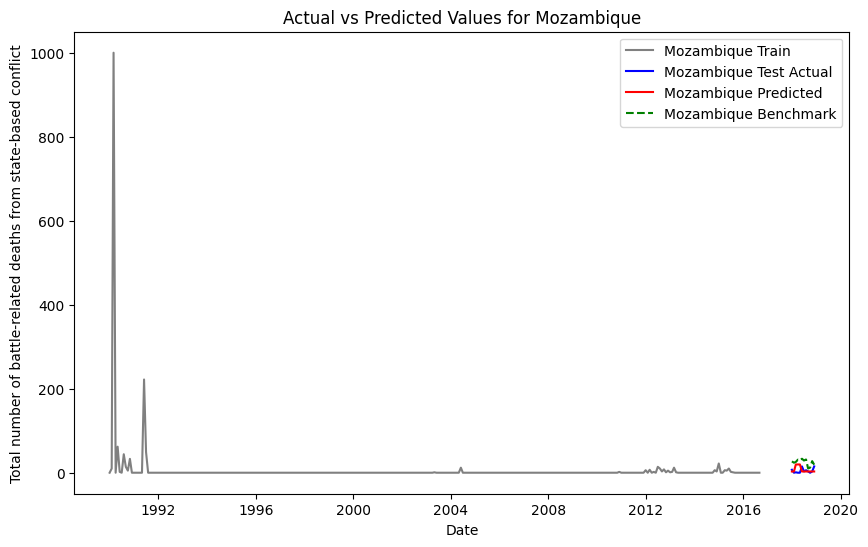

Skipping South Africa as all actuals are 0
Skipping Swaziland as all actuals are 0


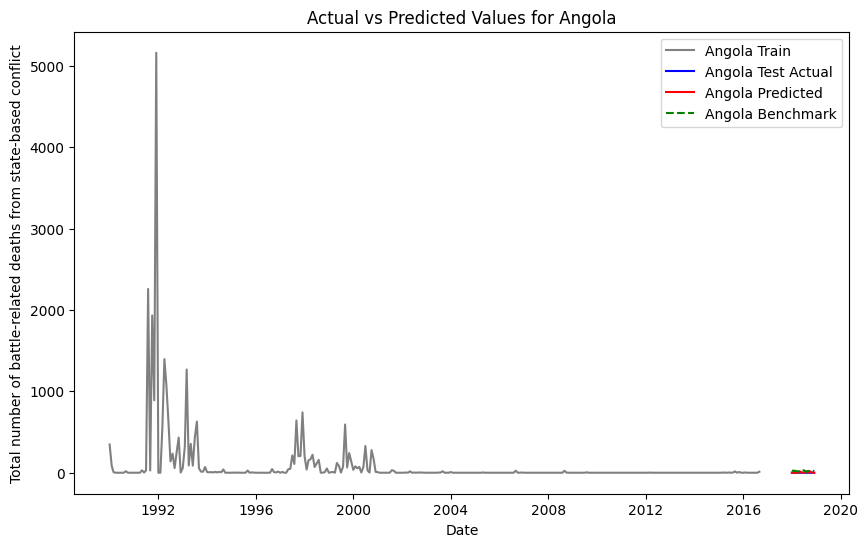

Skipping Congo as all actuals are 0


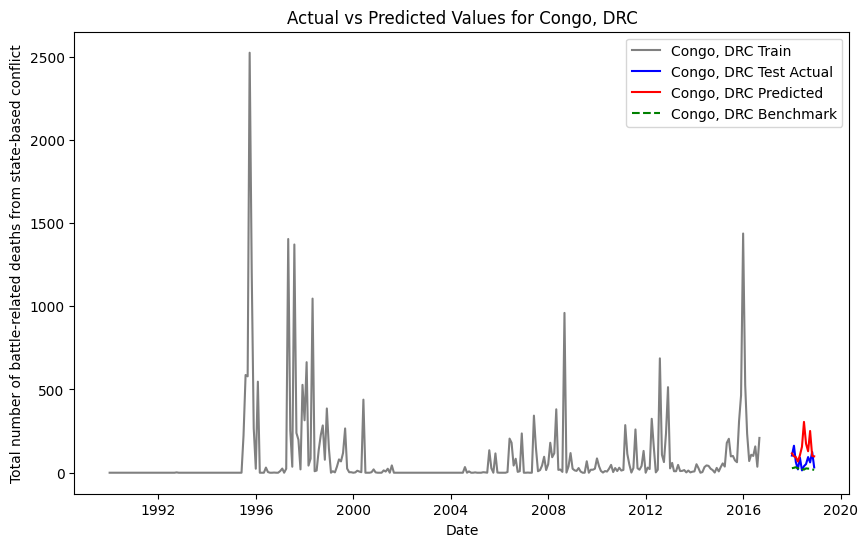

Skipping Fiji as all actuals are 0
Skipping Gabon as all actuals are 0
Skipping Namibia as all actuals are 0
Skipping New Zealand as all actuals are 0
Skipping Madagascar as all actuals are 0
Skipping Mauritius as all actuals are 0
Skipping Timor Leste as all actuals are 0


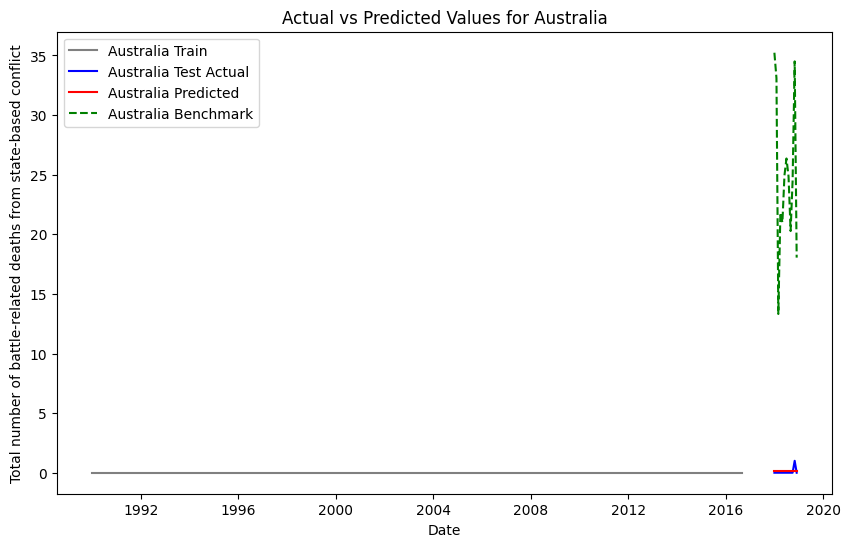

Skipping Papua New Guinea as all actuals are 0
Skipping Solomon Is. as all actuals are 0
Skipping Canada as all actuals are 0
Skipping Germany as all actuals are 0
Skipping China as all actuals are 0
Skipping Malaysia as all actuals are 0
Skipping Singapore as all actuals are 0


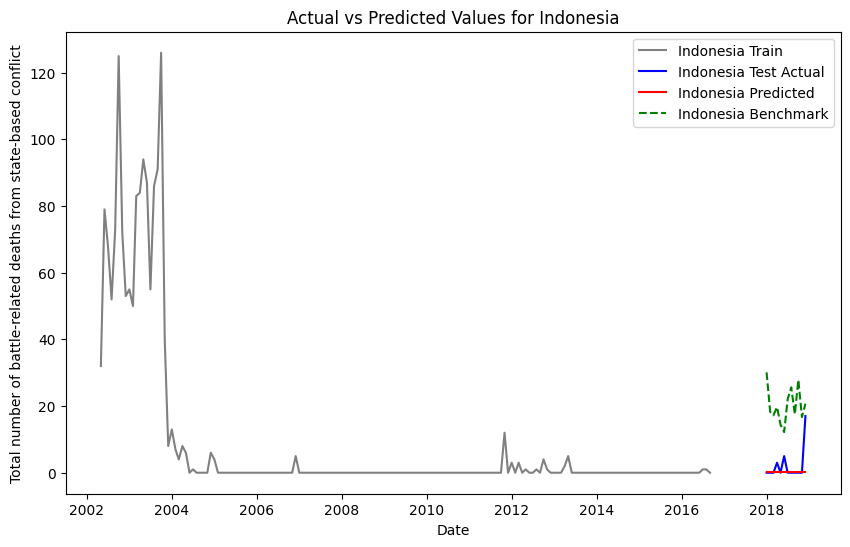

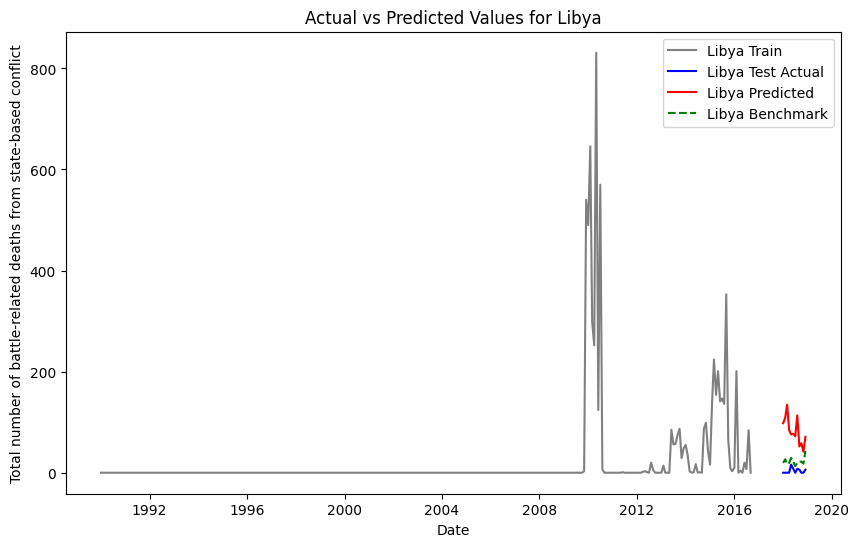

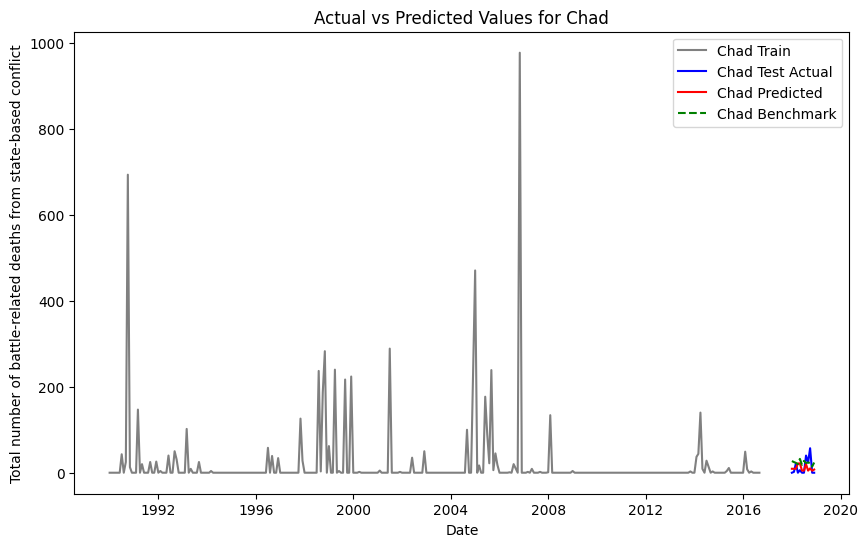

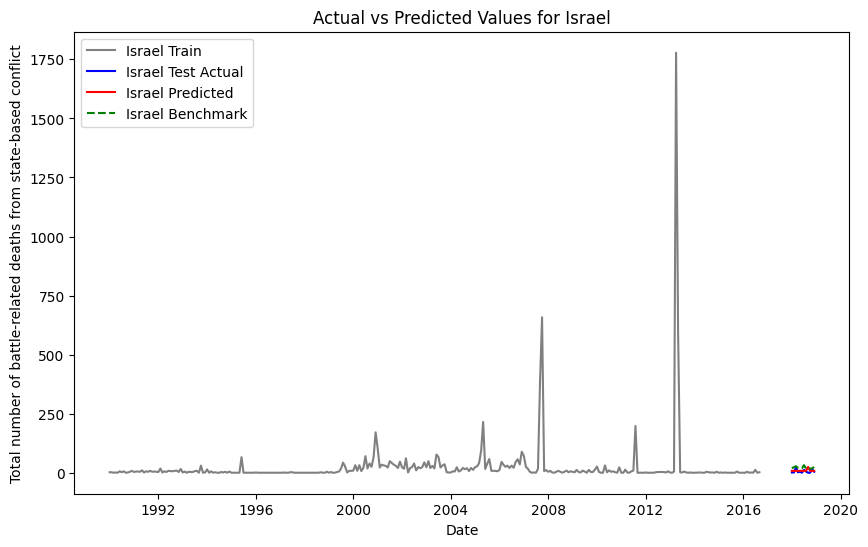

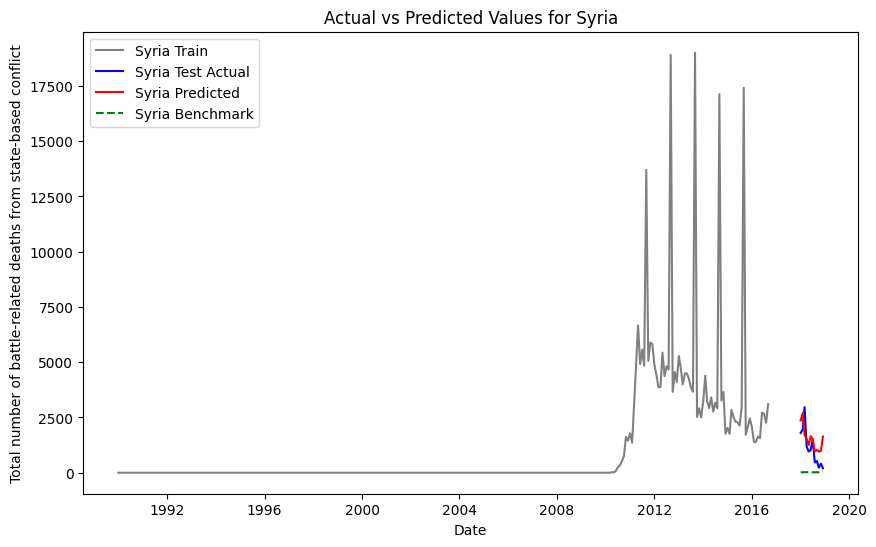

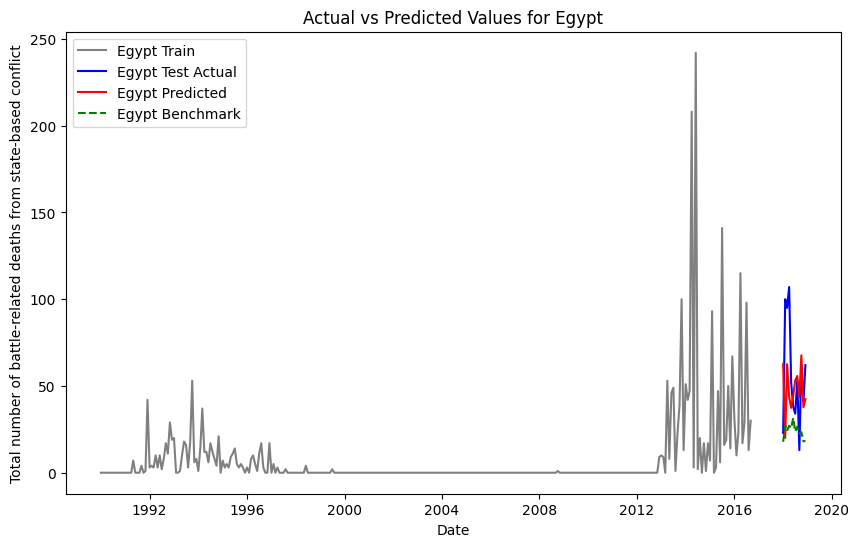

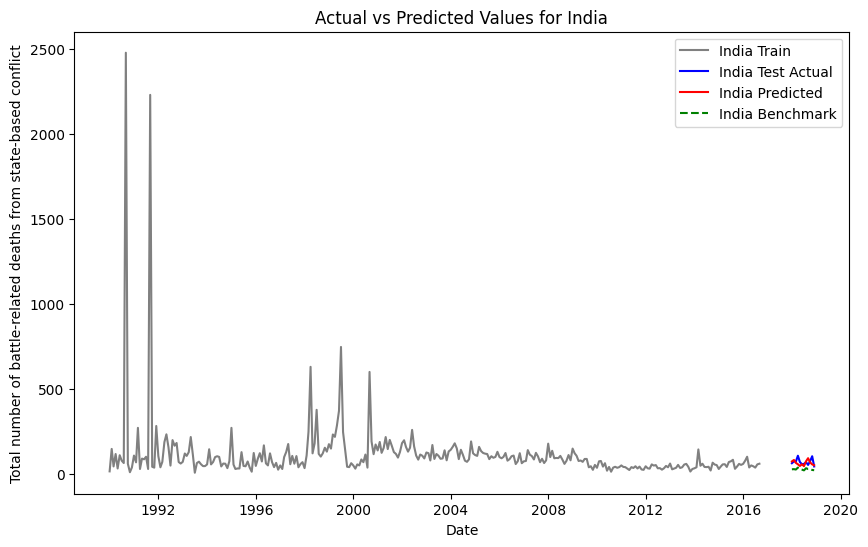

Skipping Montenegro as all actuals are 0
Skipping Serbia as all actuals are 0
Skipping United States as all actuals are 0
Skipping Uganda as all actuals are 0


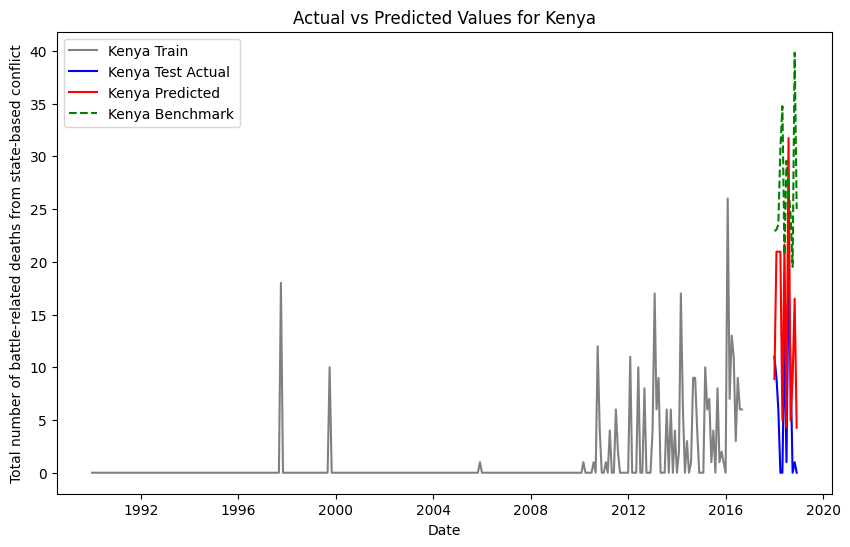

Skipping Tanzania as all actuals are 0
Skipping Morocco as all actuals are 0
Skipping Mauritania as all actuals are 0


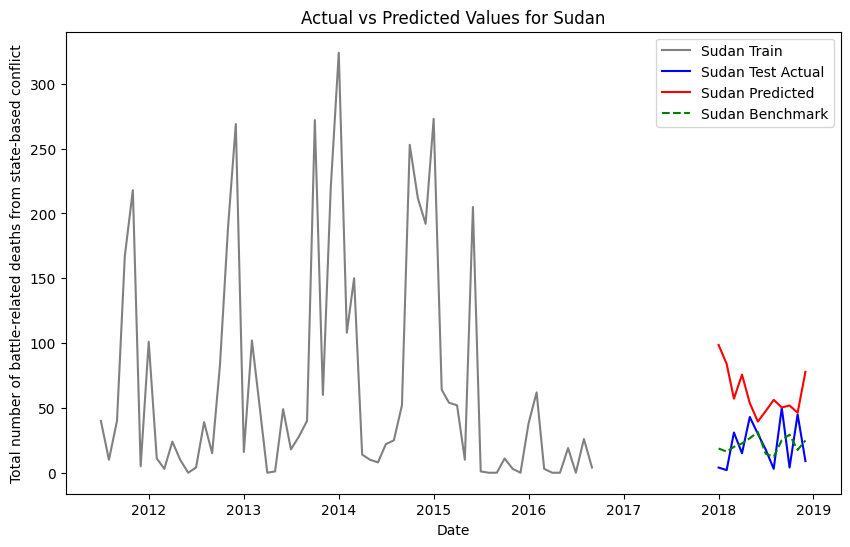

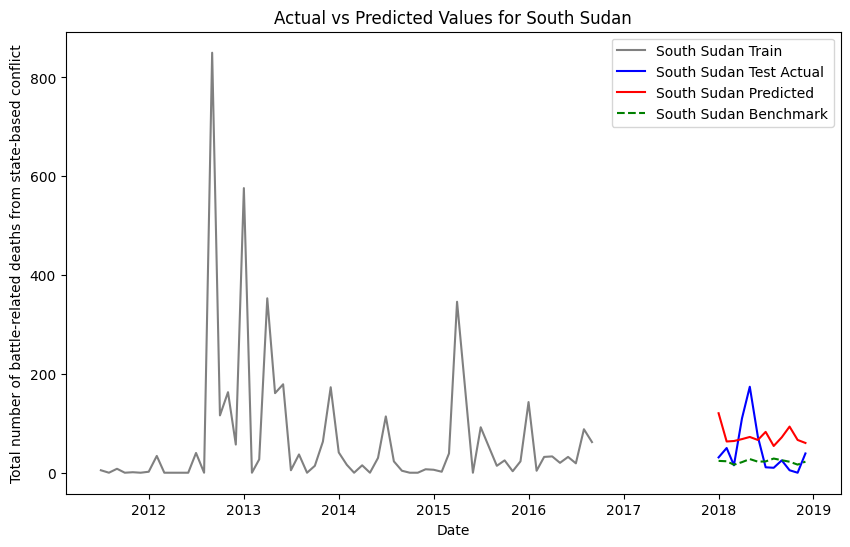

In [75]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

country_list = pd.read_csv('data/country_list.csv')

country_ids = test_df['country_id'].unique().tolist()
# drop country if all actuals are 0
# [country_ids.remove(country_id) for country_id in country_ids if test_df[test_df['country_id'] == country_id][target].sum() == 0]

for country_id in country_ids:
    # Data for this country
    this_country_test = test_df[test_df['country_id'] == country_id]
    this_country_train = train_df[train_df['country_id'] == country_id]
    country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

    # skip country if all actuals are 0
    if this_country_test[target].sum() == 0:
        print(f"Skipping {country_name} as all actuals are 0")
        continue

    # Creating plot
    plt.figure(figsize=(10, 6))

    # Plot training data
    plt.plot(this_country_train['date'], this_country_train[target], label=f'{country_name} Train', color='gray',
             linestyle='-', marker='')

    # Plot test actual data
    plt.plot(this_country_test['date'], this_country_test[target], label=f'{country_name} Test Actual', color='blue',
             linestyle='-', marker='')

    # Plot predicted data
    plt.plot(this_country_test['date'], this_country_test['predictions'], label=f'{country_name} Predicted',
             color='red', linestyle='-', marker='')

    # plot benchmark
    benchmark_country = benchmark_model[benchmark_model['country_id'] == country_id]
    plt.plot(benchmark_country['date'], benchmark_country['outcome'], label=f'{country_name} Benchmark', color='green',
             linestyle='--', marker='')

    # # plot actuals
    # actuals_country = actuals_model[actuals_model['country_id'] == country_id]
    # plt.plot(actuals_country['date'], actuals_country['ged_sb'], label=f'{country_name} Actuals', color='purple',
    #          linestyle='--', marker='')

    # Adding title and labels
    plt.title(f"Actual vs Predicted Values for {country_name}")
    plt.xlabel("Date")
    plt.ylabel("Total number of battle-related deaths from state-based conflict")
    plt.legend()

    # Show plot
    plt.show()

In [76]:
import plotly.graph_objects as go

PLOT_ONE_FIGURE = False
if PLOT_ONE_FIGURE:
    # Assuming country_list, test_df, and train_df are already loaded
    # Creating one figure for all countries
    fig = go.Figure()

    country_ids = test_df['country_id'].unique().tolist()

    for country_id in country_ids:
        # Data for this country
        this_country_test = test_df[test_df['country_id'] == country_id]
        this_country_train = train_df[train_df['country_id'] == country_id]
        country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

        # Add traces for Train Actual
        fig.add_trace(
            go.Scatter(x=this_country_train['date'], y=this_country_train[target], name=f'{country_name} Train',
                       mode='lines', line=dict(color='gray', width=1))
        )

        # Add traces for Test Actual
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test[target], name=f'{country_name} Test Actual',
                       mode='lines', line=dict(color='blue', width=1))
        )

        # Add traces for Predicted
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test['predictions'],
                       name=f'{country_name} Predicted', mode='lines', line=dict(color='red', dash='dot', width=1))
        )

    # Add figure title and adjust layout
    fig.update_layout(
        title_text="Actual vs Predicted Values Across Countries",
        xaxis_title="Date",
        yaxis_title="GED_SB Value",
        legend_title="Legend",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Show plot
    fig.show()